### Import Libraries

In [ ]:
!unzip /content/drive/"My Drive"/"Arrythmia "/ECGDataDenoised.zip

Streaming output truncated to the last 5000 lines.
  inflating: ECGDataDenoised/MUSE_20180116_125802_57000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125812_73000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125822_43000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125825_58000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125842_09000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125845_27000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125847_39000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125906_02000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125918_29000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125919_34000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125921_43000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125925_64000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125946_45000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125948_54000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_130000_80000.csv  
  inflating: ECGDat

In [ ]:
!pip install -q -U tensorflow_addons
!pip install neurokit2
# !pip install wfdb

     |████████████████████████████████| 1.1 MB 29.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 34.0 MB/s 


In [ ]:
import sys
import os

from tensorflow.keras.layers import BatchNormalization
%matplotlib inline
sampling_rate=500
arr_folder_location = "/content/drive/MyDrive/Arrythmia /"
sys.path.append(os.path.abspath(arr_folder_location))

In [ ]:
from arryhthmia_backend import *

File Import Success


In [ ]:
def extractor(case,id):
  cnt_id={}
  nsr_det_rri = []
  nsr_det_rri = np.array(nsr_det_rri)
  afib_det_rri = []
  afib_det_rri = np.array(afib_det_rri)
  afl_det_rri = []
  afl_det_rri = np.array(afl_det_rri)
  afl_list = []
  for i in id:
    label=subject_label[all_subjects[i]]
    if label in cnt_id:
      cnt_id[label]+=1
    else:
      cnt_id[label]=1
    name=all_subjects[i]
    if(label=='nsr'):
      nsr_det_rri=np.append(nsr_det_rri,nsr_rri[name])
    elif(label=='afl'):
      afl_list.append(name)
      afl_det_rri=np.append(afl_det_rri,afl_rri[name])
    else:
      afib_det_rri=np.append(afib_det_rri,afib_rri[name])
    ## 
  print(case,":",cnt_id)
  print(len(afib_det_rri),len(nsr_det_rri),len(afl_det_rri))

  p1 = np.random.permutation(afl_list)
  p2 = np.random.permutation(afl_list)
  # print(len(p1)," , ",len(p2))
  for k in p1:
    afl_det_rri=np.append(afl_det_rri,afl_rri[k])
  for k in p2:
    afl_det_rri=np.append(afl_det_rri,afl_rri[k])
  print("After patient Scrambling:",len(afl_det_rri))


  afib_vectors = round_robin(afib_det_rri)
  afl_vectors = round_robin(afl_det_rri)
  nsr_vectors = round_robin(nsr_det_rri)
  len__puncture = min(len(afib_vectors),min(len(nsr_vectors),len(afl_vectors)))
  afib_vectors = afib_vectors[:len__puncture]
  afl_vectors = afl_vectors[:len__puncture]
  nsr_vectors = nsr_vectors[:len__puncture]

  afib_rr = pd.DataFrame(afib_vectors)
  afib_rr['label']='afib'
  nsr_rr = pd.DataFrame(nsr_vectors)
  nsr_rr['label']='nsr'
  afl_rr = pd.DataFrame(afl_vectors)
  afl_rr['label']='afl'

  full_data_with_rr=pd.concat([afib_rr,nsr_rr,afl_rr])
  dict = {'nsr': 0, 'afib': 1, 'afl':2}
  full_data_with_rr.replace({'label': dict},inplace=True)
  return full_data_with_rr



def train_1_fold(train,test,num_epochs):
    # train=pd.read_csv("/content/drive/MyDrive/train_with_rr_20.csv")
    train = train.sample(frac=1).reset_index(drop=True)
    train = train.sample(frac=1).reset_index(drop=True)
    full_data_with_rr=train
    full_test_set=test

    X_arhy_train, X_arhy_val, y_arhy_train, y_arhy_val = train_test_split(full_data_with_rr.iloc[:,:-1].values, full_data_with_rr.iloc[:,-1].values,test_size=0.1, random_state=42)

    X_arhy_test, X_arhy_val, y_arhy_test, y_arhy_val = train_test_split(X_arhy_val,y_arhy_val,test_size=0.5, random_state=42)

    # The 1D convolutions expect an extra dimension in the input data 
    X_arhyl_train = np.expand_dims(X_arhy_train, -1)
    y_arhyl_train = np.expand_dims(y_arhy_train, -1)
    X_arhyl_val = np.expand_dims(X_arhy_val, -1)
    y_arhyl_val = np.expand_dims(y_arhy_val, -1)
    X_arhyl_test = np.expand_dims(X_arhy_test, -1)
    y_arhyl_test = np.expand_dims(y_arhy_test, -1)

    N = X_arhyl_train.shape[0]
    batch_size = 16
    iterations = N/batch_size
    step_size= 2 * iterations

    optimizer = keras.optimizers.Adam(lr=0.001)
    model = get_resnet_model() 
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-02, max_steps=50, smoothing=0.6)
    _ = model.fit(X_arhyl_train, y_arhyl_train, batch_size=256, epochs=num_epochs, callbacks=[lr_finder], verbose=False)
    lr_finder.plot()

    lr_schedule = CyclicalLearningRate(1e-5, 1e-2, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
    
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    m_resnet_model = get_resnet_model()

    save_best_weights = ModelCheckpoint(filepath="/content/drive/My Drive/Arrythmia /weights.hdf5", verbose=0, save_best_only=True)

    m_resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = m_resnet_model.fit(X_arhyl_train, y_arhyl_train, validation_data=(X_arhyl_val, y_arhyl_val), 
                                shuffle=True, batch_size=16, epochs=num_epochs, callbacks=[save_best_weights])
    pretty_plot(history, 'loss', lambda x: np.argmin(x))
    pretty_plot(history, 'accuracy', lambda x: np.argmax(x))
    m_resnet_model.load_weights("/content/drive/My Drive/Arrythmia /weights.hdf5")
    print("\n****** Val data (used to tune hyperparameters for model) *****\n")
    test_stats = m_resnet_model.evaluate(X_arhyl_test, y_arhyl_test)   
    test_acc = round(test_stats[1],2)
    
    y_pred = tf.argmax(m_resnet_model.predict(X_arhyl_test), axis=-1)
    # Compute confusion matrix
    cnf_matrix = sklearn.metrics.confusion_matrix(y_arhy_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['NSR', 'AFIB','AFL'],
                        title='Confusion matrix, without normalization')

    X_arhy_test_10split = full_test_set.iloc[:,:-1].values
    y_arhy_test_10split = full_test_set.iloc[:,-1].values

    print("\n****** TEST-set data (unseen to model) *****\n")
    ###########
    val_stats=m_resnet_model.evaluate(X_arhy_test_10split, y_arhy_test_10split)
    val_acc = round(val_stats[1],4)
    
    y_pred = tf.argmax(m_resnet_model.predict(X_arhy_test_10split), axis=-1)
    # Compute confusion matrix
    cnf_matrix = sklearn.metrics.confusion_matrix(y_arhy_test_10split, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['NSR', 'AFIB','AFL'],
                        title='Confusion matrix, without normalization')
    print(cnf_matrix.diagonal()/cnf_matrix.sum(axis=1))

    print("Final Accuracy:",round(val_acc*100,2),"%\n")
    return round(float(val_acc*100),2)


In [ ]:
labels = pd.read_excel('/content/drive/MyDrive/Arrythmia /Diagnostics.xlsx')
len(labels)

10646

In [ ]:
labels=labels[(labels['Rhythm']=='AFIB') | (labels['Rhythm']=='AF') |(labels['Rhythm']=='SR')]
labels.reset_index(inplace=True,drop=True)
labels['Rhythm'].value_counts()

SR      1826
AFIB    1780
AF       445
Name: Rhythm, dtype: int64

### Preprocessing

In [ ]:
afib_files = labels[labels['Rhythm']=="AFIB"]['FileName'].tolist()
afib_files.remove('MUSE_20180116_131253_72000')
nsr_files = labels[labels['Rhythm']=="SR"]['FileName'].tolist()
afl_files = labels[labels['Rhythm']=="AF"]['FileName'].tolist()
all_files = afib_files+nsr_files+afl_files

In [ ]:
nsr_rri=append_r_peaks(nsr_files,"nsr",sampling_rate=500)
afib_rri=append_r_peaks(afib_files,"afib",sampling_rate=500)
afl_rri=append_r_peaks(afl_files,"afl",sampling_rate=500)
# to verify total no. of total RR Intervals for each class and 
# Extract RR Peaks into a dictionary with filename

100%|██████████| 1826/1826 [00:38<00:00, 47.32it/s]


Total no. of RR Intervals in nsr  class is: 20520 



 91%|█████████ | 1619/1779 [00:32<00:03, 50.43it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1779/1779 [00:35<00:00, 49.49it/s]


Total no. of RR Intervals in afib  class is: 25124 



100%|██████████| 445/445 [00:08<00:00, 50.07it/s]

Total no. of RR Intervals in afl  class is: 7491 



In [ ]:
# nsr_extraction_rr = pd.DataFrame.from_dict(nsr_rri,orient='index')
# afl_extraction_rr = pd.DataFrame.from_dict(afl_rri,orient='index')
# afib_extraction_rr = pd.DataFrame.from_dict(afib_rri,orient='index')

In [ ]:
all_subjects=all_files
subject_label = {}
for i in afib_files:
    subject_label[i] = 'afib'
for i in nsr_files:
    subject_label[i] = 'nsr'
for i in afl_files:
    subject_label[i] = 'afl'

In [ ]:
for i in range(0,10):
  print(i)

0
1
2
3
4
5
6
7
8
9


In [ ]:
% From: http://clinengnhs.liv.ac.uk/
function [z,nf]=ougp_gpousmooth2(x,y,wc,type)

    % Analytical form of inverse covariance for a generalised
    % 1-dimensional Ornstein-Uhlenbeck process

    % INPUTS
    % x - times
    % y - data
    % wc - cutoff frequency (or 2-vector of frequencies for bandpass)
    %      (expressed as fraction of Nyquist frequency)  
    % type - string: lp, hp, bp (for low-pass, high-pass or band-pass)
    %       default: lp
    % OUTPUTS
    % z - smoothed data
    % nf - estimate of the Nyquist frequency
    % A Eleuteri - 27/02/2009
    % -----------------------------------------------------------------------
    % Reference paper: G. B. Rybicki and W. H. Press, Physical Review Letters
    % Vol. 74, Num. 7, p.1060-1063
    % http://dx.doi.org/10.1007/s11517-012-0928-2

    if nargin<4
        type='lp';
    end

    if length(wc)==2
        type='bp';
    end

    nf=median(1./diff(x))/2; % estimate of the Nyquist frequency

    if (strcmp(type,'lp'))
        z=gouinvcovfilt(x,y,wc*nf,type);
    elseif strcmp(type,'hp')
        z=gouinvcovfilt(x,y,wc*nf,type);
    elseif strcmp(type,'bp')
        tmp=gouinvcovfilt(x,y,wc(2)*nf,'lp');
        z=gouinvcovfilt(x,tmp,wc(1)*nf,'hp');
    else
        error('unrecognised option or wrong number of frequencies.');
    end

    return



    function z=gouinvcovfilt(x,y,wc,type)
        if length(wc)>1
            error(['frequency must be a scalar for the ',type,' option.']);
        end

        T=length(x);
        if (strcmp(type,'lp'))
            k=sqrt(2)*pi*(sqrt(2)-1)^(-1/4);
        else
            k=sqrt(2)*pi*(sqrt(2)-1)^(1/4);
        end

        w=k*(1+1j)*wc*np.diff(x);
        r=exp(-w);
        e=r./(1-r.^2);
        re=r.*e;
        d=1+[re;0]+[0;re];
        invK=spdiags([-[e;0],d,-[0;e]],-1:1,T,T); % inverse covariance matrix
        f=cmplxtrf(y,w);
        u=(invK)\(f);
        if (strcmp(type,'lp'))
            z=y-real(u);
        else
            z=real(u);
        end
        return

    function f=cmplxtrf(y,w)
        f=zeros(size(y));
        T=length(y);
        dy=diff(y);
        f(1)=-0.5*dy(1)/w(1);
        f(2:T-1)=0.5*(-dy(2:end)./w(2:end)+dy(1:end-1)./w(1:end-1));
        f(T)=0.5*dy(end)/w(end);
    return

### OUGP Detrend Filter

In [ ]:
def cmplxtrf(y,w):
  f=np.zeros(len(y))
  T=len(y) #since y is 1d
  dy=np.diff(y)
  end=len(dy)
  f[0]=-0.5*dy[0]/w[0]
  for i in range(1,T-2):
    f[i]=0.5*((-dy[i+1]/w[i+1])+dy[i-1]/w[i-1])
  f[T-1]=0.5*dy[end-1]/w[end-1]
  return f

def gouinvcovfilt(x,y,wc,type_str):
  if length(wc)>1:
    print('frequency must be a scalar')
  if type_str=="lp":
    k=sqrt(2)*pi*(sqrt(2)-1)^(-1/4)
  else:
    k=sqrt(2)*pi*(sqrt(2)-1)^(1/4)
  w=k*(1+1j)*wc*np.diff(x)
  r=np.exp(-w)  
  e=r/(1-r**2)
  re=r*e
  --------

  d=1+[re;0]+[0;re]
  invK=spdiags([-[e;0],d,-[0;e]],-1:1,T,T);  #inverse covariance matrix
  f=cmplxtrf(y,w);
  u=(invK)\(f);
  if (strcmp(type_str,'lp'))
      z=y-real(u);
  else
      z=real(u);
  end
  return

  


In [ ]:

  d=1+[re;0]+[0;re]
  invK=spdiags([-[e;0],d,-[0;e]],-1:1,T,T);  #inverse covariance matrix
  f=cmplxtrf(y,w);
  u=(invK)\(f);
  if (strcmp(type,'lp'))
      z=y-real(u);
  else
      z=real(u);
  end
  return


In [ ]:
import math
import numpy as np
wc=0.4 #or 5
type_str = "lp"
x = [1,2,3,4,5,6,7,8,9,10]
if type_str=="lp":
  k=math.sqrt(2)*math.pi*(math.sqrt(2)-1)**(-1/4)
else:
  k=math.sqrt(2)*math.pi*(math.sqrt(2)-1)**(1/4)
w=k*(1+1j)*wc*np.diff(x)
r=np.exp(-w)  
e=r/(1-r**2)
re=r*e

### Labelling encoding {'nsr': 0, 'afib': 1, 'afl':2}


In [ ]:
def get_resnet_model():
  def residual_block(X, kernels, stride,F_size):
    out = tf.keras.layers.Conv1D(F_size,kernels, stride, padding='same')(X)
    # out = BatchNormalization()(out)
    out = tf.keras.activations.relu(out)    
    out = tf.keras.layers.add([X, out])
    out = tf.keras.layers.MaxPool1D(1, 3)(out)
    return out

  kernels = 32
  stride = 1

  ### INPUT
  inputs = tf.keras.layers.Input([100,1])
  ### BLOCK 1
  X = tf.keras.layers.Conv1D(64,8, stride)(inputs)  
  X = tf.keras.activations.relu(X)
  # X = BatchNormalization()(X)
  X = tf.keras.layers.Conv1D(64,5, stride)(inputs)  
  X = tf.keras.activations.relu(X)
  # X = BatchNormalization()(X)
  X = tf.keras.layers.Conv1D(64,3, stride)(inputs)  
  X = tf.keras.activations.relu(X)
  # X = BatchNormalization()(X)

  ### Residual Block
  X = residual_block(X, kernels, stride,64)
  X = tf.keras.activations.relu(X)  

  ### BLOCK 2
  X = tf.keras.layers.Conv1D(128,8, stride)(inputs)
  X = tf.keras.activations.relu(X)
  # X = BatchNormalization()(X)
  X = tf.keras.layers.Conv1D(128,5, stride)(inputs)
  X = tf.keras.activations.relu(X)
  # X = BatchNormalization()(X)
  X = tf.keras.layers.Conv1D(128,3, stride)(inputs)
  X = tf.keras.activations.relu(X)
  # X = BatchNormalization()(X)

  ### Residual Block  
  X = residual_block(X, kernels, stride,128)
  X = tf.keras.activations.relu(X)  

  ### BLOCK 3
  X = tf.keras.layers.Conv1D(128,8, stride)(inputs)
  X = tf.keras.activations.relu(X)
  # X = BatchNormalization()(X)
  X = tf.keras.layers.Conv1D(128,5, stride)(inputs)
  X = tf.keras.activations.relu(X)
  # X = BatchNormalization()(X)
  X = tf.keras.layers.Conv1D(128,3, stride)(inputs)
  X = tf.keras.activations.relu(X)
  # X = BatchNormalization()(X)
  
  ### Residual Block  
  X = residual_block(X, kernels, stride,128)
  
  # X = tf.keras.layers.Flatten()(X)
  X = tf.keras.layers.GlobalAveragePooling1D()(X)

  # X = tf.keras.layers.Dense(64, activation='relu')(X)
  # X = tf.keras.layers.Dense(32, activation='relu')(X)

  
  X = tf.keras.layers.Dense(8, activation='relu')(X) ##### this was used before
  output =  tf.keras.layers.Dense(5, activation='softmax')(X)
  
  model = tf.keras.Model(inputs=inputs, outputs=output)
  return model


train : {'afib': 1592, 'nsr': 1652, 'afl': 401}
22573 18567 6786
After patient Scrambling: 20358


100%|██████████| 18567/18567 [00:00<00:00, 444797.79it/s]


test : {'afib': 187, 'nsr': 174, 'afl': 44}
2551 1953 705
After patient Scrambling: 2115


100%|██████████| 1953/1953 [00:00<00:00, 421654.18it/s]



#@#@#@#@#@ Working on FOLD: 1 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
3134/3134 [==============================] - 16s 5ms/step - loss: 0.3151 - accuracy: 0.8747 - val_loss: 0.1920 - val_accuracy: 0.9304
Epoch 2/10
3134/3134 [==============================] - 14s 4ms/step - loss: 0.1329 - accuracy: 0.9520 - val_loss: 0.0455 - val_accuracy: 0.9835
Epoch 3/10
3134/3134 [==============================] - 14s 4ms/step - loss: 0.0369 - accuracy: 0.9876 - val_loss: 0.0231 - val_accuracy: 0.9928
Epoch 4/10
3134/3134 [==============================] - 14s 4ms/step - loss: 0.0045 - accuracy: 0.9987 - val_loss: 0.0028 - val_accuracy: 0.9996
Epoch 5/10
3134/3134 [==============================] - 13s 4ms/step - loss: 0.0050 - accuracy: 0.9985 - val_loss: 0.0187 - val_accuracy: 0.9935
Epoch 6/10
3134/3134 [==============================] - 13s 4ms/step - loss: 0.0220 - accuracy: 0.9940 - val_loss: 0.0108 - val_accuracy: 0.9982
Epoch 7/10
3134/3134 [==============================] - 14s 4ms/step - loss: 0.0088 - accuracy: 0.9972 - val_loss: 0.0125 - val_ac

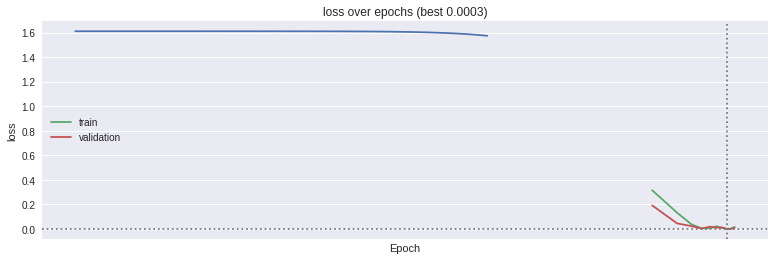

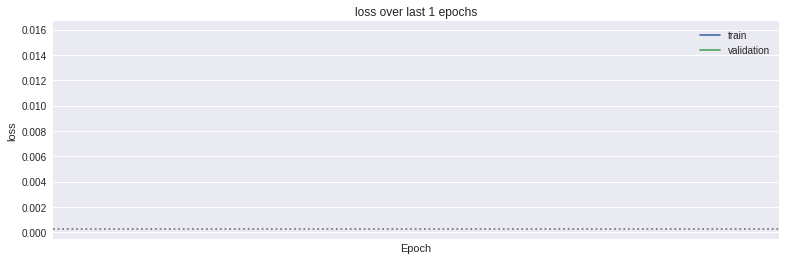

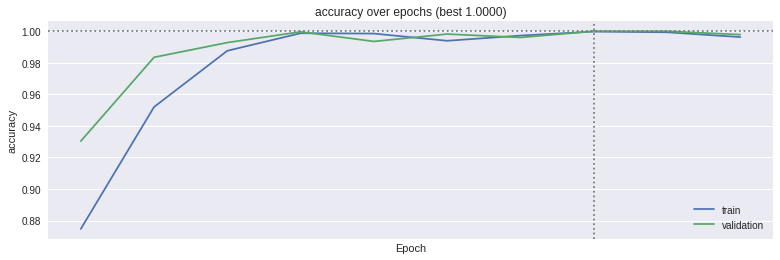

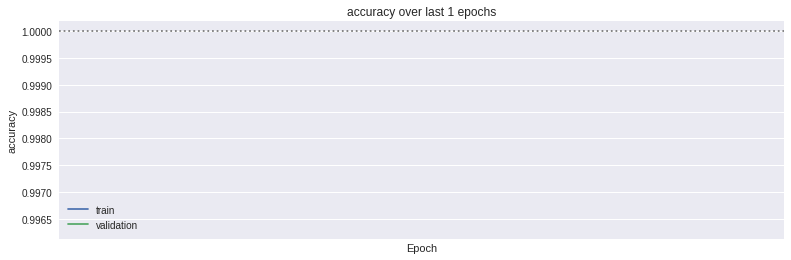


****** Val data (used to tune hyperparameters for model) *****

88/88 [==============================] - 0s 4ms/step - loss: 0.0015 - accuracy: 0.9993
Confusion matrix, without normalization
[[927   0   1]
 [  0 933   0]
 [  1   0 923]]

****** TEST-set data (unseen to model) *****

184/184 [==============================] - 1s 3ms/step - loss: 0.3646 - accuracy: 0.9411
Confusion matrix, without normalization
[[1865    0   88]
 [   0 1912   41]
 [   4  212 1737]]
[0.95 0.98 0.89]
Final Accuracy: 94.11 %

10 fold acc: [94.11]


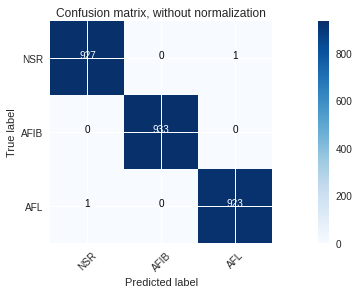

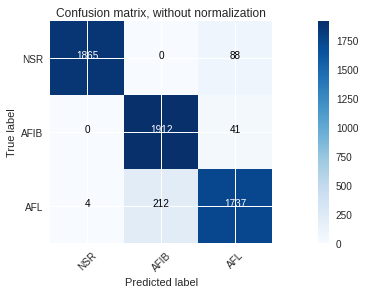

In [ ]:
# scikit-learn k-fold cross-validation
data=all_subjects

# prepare cross validation
kfold = KFold(10,shuffle=True,random_state=42)
all_fold_acc = []
# enumerate splits
count=1
for train, test in kfold.split(data):  
  full_train_set = extractor("train",train)
  full_test_set = extractor("test",test)
  print("\n#@#@#@#@#@ Working on FOLD:",count,"#@#@#@#@#@\n")
  accuracy_1_fold = train_1_fold(full_train_set,full_test_set,10)
  all_fold_acc.append(accuracy_1_fold)
  count+=1
  break
  #1 fold done call rest part in function to complete your k fold cv
  # if(count == 2):
    # break
print("10 fold acc:",all_fold_acc)

### Testing on Other Datasets

In [ ]:
# import glob
# m_resnet_model = get_resnet_model(10)
# m_resnet_model.load_weights("/content/drive/My Drive/Arrythmia /weights.hdf5")

# path = r'/content/musecare_rr_intervals' # use your path
# all_files = glob.glob(path + "/*.csv")

# li = []
# name = []
# for filename in all_files:
#     df = pd.read_csv(filename, index_col=None, header=None)
#     one_list=df.iloc[0]
#     new_df=pd.DataFrame()
#     for i in range(0,len(one_list)):
#       if(one_list[i]!=one_list[i+1]):
#         one_list=one_list[i+1:i+101]
#         one_list=one_list/1000
#         one_list.reset_index(inplace=True,drop=True)
#         detrended_rri = signal.detrend(one_list, axis= -1, type='constant', bp=0, overwrite_data=False).tolist()
        
#         new_df=new_df.append(pd.DataFrame(detrended_rri).transpose())
#         break
#     li.append(new_df)
#     name.append(filename)

# test_data = pd.concat(li, axis=0, ignore_index=True)
# test_data['filename']=name

# print(test_data.shape[0] - test_data.dropna().shape[0])
# #hence 81 files have null values, will drop them

# test_data=test_data.dropna()
# test_data.reset_index(inplace=True,drop=True)

# X_ckecker=test_data.iloc[:,:-1].values
# preds=tf.argmax(m_resnet_model.predict(X_ckecker), axis=-1)

# test_data['predicted_class']=preds
# dct= {0:'nsr', 1:'afib', 2:'afl'}
# test_data=test_data.replace({"predicted_class": dct})
# test_data['predicted_class'].value_counts()

In [ ]:
# test_data.to_csv("result_arr_ppg_RRi.csv",index=False)

### Testing on PTB Diagnostic ECG database

In [ ]:
# !wget "https://www.physionet.org/static/published-projects/ptbdb/ptb-diagnostic-ecg-database-1.0.0.zip"

--2022-04-06 09:13:40--  https://www.physionet.org/static/published-projects/ptbdb/ptb-diagnostic-ecg-database-1.0.0.zip
Resolving www.physionet.org (www.physionet.org)... 18.18.42.54
Connecting to www.physionet.org (www.physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1790456359 (1.7G) [application/zip]
Saving to: ‘ptb-diagnostic-ecg-database-1.0.0.zip.1’

    ptb-diagnostic-   3%[                    ]  63.44M  52.7MB/s               ^C


Each csv file includes information of 15 simultaneously measured signals:12 leads (i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5, v6) together with the 3 Frank lead ECGs (vx, vy, vz).
The sampling frequency of ECG is 1000Hz.

In [ ]:
!wget -r -N -c -np https://physionet.org/files/ptbdb/1.0.0/
!pip install wfdb
import wfdb #WaveForm-Database package. A library of tools for reading, writing, and processing WFDB signals and annotations.
import pandas as pd
import numpy as np
import sys
import glob
import os
from glob import glob
PATH = "/content/physionet.org/files/ptbdb/1.0.0/"
sys.path.append(os.path.abspath(PATH))

nsr_patients =['patient104/s0306lre','patient105/s0303lre','patient116/s0302lre','patient117/s0291lre','patient117/s0292lre',
      'patient121/s0311lre','patient122/s0312lre','patient131/s0273lre','patient150/s0287lre','patient155/s0301lre',
      'patient156/s0299lre','patient165/s0322lre','patient165/s0323lre','patient166/s0275lre','patient169/s0328lre',
      'patient169/s0329lre','patient170/s0274lre','patient172/s0304lre','patient173/s0305lre','patient174/s0300lre',
      'patient174/s0324lre','patient174/s0325lre','patient180/s0374lre','patient180/s0475_re','patient180/s0476_re',
      'patient180/s0477_re','patient180/s0490_re','patient180/s0545_re','patient180/s0561_re','patient182/s0308lre',
      'patient184/s0363lre','patient185/s0336lre','patient198/s0402lre','patient198/s0415lre','patient214/s0436_re',
      'patient229/s0452_re','patient229/s0453_re','patient233/s0457_re','patient233/s0458_re','patient233/s0459_re',
      'patient233/s0482_re','patient233/s0483_re','patient234/s0460_re','patient235/s0461_re','patient236/s0462_re',
      'patient236/s0463_re','patient236/s0464_re','patient237/s0465_re','patient238/s0466_re','patient239/s0467_re',
      'patient240/s0468_re','patient241/s0469_re','patient241/s0470_re','patient242/s0471_re','patient243/s0472_re',
      'patient244/s0473_re','patient245/s0474_re','patient245/s0480_re','patient246/s0478_re','patient247/s0479_re',
      'patient248/s0481_re','patient251/s0486_re','patient251/s0503_re','patient251/s0506_re','patient252/s0487_re',
      'patient255/s0491_re','patient260/s0496_re','patient263/s0499_re','patient264/s0500_re','patient266/s0502_re',
      'patient267/s0504_re','patient276/s0526_re','patient277/s0527_re','patient279/s0531_re','patient279/s0532_re',
      'patient279/s0533_re','patient279/s0534_re','patient284/s0543_re','patient284/s0551_re','patient284/s0552_re']

In [ ]:
files = nsr_patients

for i in tqdm(range(0,len(files))):
	recordname=PATH+str(files[i])+'.hea'
	
	recordname_new=recordname[-23:-4] #Extracting just the filename part (will differ from database to database)
	# print(recordname_new)
	record = wfdb.rdsamp(PATH+recordname_new) # rdsamp() returns the signal as a numpy array  
	record=np.asarray(record[0])
	path=PATH+recordname_new+".csv"
	np.savetxt(path,record,delimiter=",") #Writing the CSV for each record
	
print("\nAll files done!")

100%|██████████| 80/80 [02:15<00:00,  1.69s/it]


All files done!


In [ ]:
# With normal flatten layer at the end, without batch Norm.
methods=["interpolation","FFT","poly","numpy"]
m_resnet_model = get_resnet_model()
m_resnet_model.load_weights("/content/drive/My Drive/Arrythmia /weights.hdf5")
for way in methods:
  print("Using",way,"method of Resampling\n")
  filenames=[]
  li=[]
  for i in tqdm(range(0,len(files))):
    recordname=PATH+str(files[i])+'.csv'
    df=pd.read_csv(recordname,header=None)
    lead_II = df.iloc[:,1] #lead II
    lead_II = nk.signal_resample(lead_II, method=way,
                                              sampling_rate=1000, desired_sampling_rate=500)
    _, rpeaks = nk.ecg_peaks(lead_II, sampling_rate=500)
    rrintervals = rpeaks['ECG_R_Peaks']

    rr_diff=np.diff(rrintervals)/1000
    detrended_rri = signal.detrend(rr_diff, axis= -1, type='constant', bp=0, overwrite_data=False)
    new_df=pd.DataFrame(detrended_rri).transpose()
    li.append(new_df)
    filenames.append(files[i])
    
  test_data = pd.concat(li, axis=0, ignore_index=True)
  test_data=test_data.loc[:,:99]
  test_data['filename']=filenames 

  print("Dropping:",test_data.shape[0] - test_data.dropna().shape[0]," rows.\n")
  #hence 81 files have null values, will drop them
 
  test_data=test_data.dropna()
  test_data.reset_index(inplace=True,drop=True)

  X_ckecker=test_data.iloc[:,:-1].values
  preds=tf.argmax(m_resnet_model.predict(X_ckecker), axis=-1)

  test_data['predicted_class']=preds
  dct= {0:'nsr', 1:'Afib',2:'Afl'}
  test_data=test_data.replace({"predicted_class": dct})
  print("#### RESULTS ####\n",test_data['predicted_class'].value_counts(),"\n")

Using interpolation method of Resampling



100%|██████████| 80/80 [00:31<00:00,  2.56it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr     55
Afib    12
Afl     11
Name: predicted_class, dtype: int64 

Using FFT method of Resampling



100%|██████████| 80/80 [00:31<00:00,  2.52it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr     55
Afib    12
Afl     11
Name: predicted_class, dtype: int64 

Using poly method of Resampling



100%|██████████| 80/80 [00:30<00:00,  2.61it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr     55
Afib    12
Afl     11
Name: predicted_class, dtype: int64 

Using numpy method of Resampling



100%|██████████| 80/80 [00:30<00:00,  2.61it/s]

Dropping: 2  rows.

#### RESULTS ####
 nsr     54
Afl     12
Afib    12
Name: predicted_class, dtype: int64 



In [ ]:
#with globalavg pooling & Without Batch normalization and 
methods=["interpolation","FFT","poly","numpy"]
m_resnet_model = get_resnet_model(5)
m_resnet_model.load_weights("/content/drive/My Drive/Arrythmia /weights.hdf5")
for way in methods:
  print("Using",way,"method of Resampling\n")
  filenames=[]
  li=[]
  for i in tqdm(range(0,len(files))):
    recordname=PATH+str(files[i])+'.csv'
    df=pd.read_csv(recordname,header=None)
    lead_II = df.iloc[:,1] #lead II
    lead_II = nk.signal_resample(lead_II, method=way,
                                              sampling_rate=1000, desired_sampling_rate=500)
    _, rpeaks = nk.ecg_peaks(lead_II, sampling_rate=500)
    rrintervals = rpeaks['ECG_R_Peaks']

    rr_diff=np.diff(rrintervals)/1000
    detrended_rri = signal.detrend(rr_diff, axis= -1, type='constant', bp=0, overwrite_data=False)
    new_df=pd.DataFrame(detrended_rri).transpose()
    li.append(new_df)
    filenames.append(files[i])
    
  test_data = pd.concat(li, axis=0, ignore_index=True)
  test_data=test_data.loc[:,:99]
  test_data['filename']=filenames 

  print("Dropping:",test_data.shape[0] - test_data.dropna().shape[0]," rows.\n")
  #hence 81 files have null values, will drop them
 
  test_data=test_data.dropna()
  test_data.reset_index(inplace=True,drop=True)

  X_ckecker=test_data.iloc[:,:-1].values
  preds=tf.argmax(m_resnet_model.predict(X_ckecker), axis=-1)

  test_data['predicted_class']=preds
  dct= {0:'nsr', 1:'Afib',2:'Afl'}
  test_data=test_data.replace({"predicted_class": dct})
  print("#### RESULTS ####\n",test_data['predicted_class'].value_counts(),"\n")

Using interpolation method of Resampling



100%|██████████| 80/80 [00:30<00:00,  2.66it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr     58
Afib    16
Afl      4
Name: predicted_class, dtype: int64 

Using FFT method of Resampling



100%|██████████| 80/80 [00:29<00:00,  2.67it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr     58
Afib    15
Afl      5
Name: predicted_class, dtype: int64 

Using poly method of Resampling



100%|██████████| 80/80 [00:29<00:00,  2.71it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr     58
Afib    15
Afl      5
Name: predicted_class, dtype: int64 

Using numpy method of Resampling



100%|██████████| 80/80 [00:29<00:00,  2.68it/s]

Dropping: 2  rows.

#### RESULTS ####
 nsr     58
Afib    17
Afl      3
Name: predicted_class, dtype: int64 



In [ ]:
% From: http://clinengnhs.liv.ac.uk/
function [z,nf]=ougp_gpousmooth2(x,y,wc,type)

    # % Analytical form of inverse covariance for a generalised
    # % 1-dimensional Ornstein-Uhlenbeck process

    # % INPUTS
    # % x - times
    # % y - data
    # % wc - cutoff frequency (or 2-vector of frequencies for bandpass)
    # %      (expressed as fraction of Nyquist frequency)  
    # % type - string: lp, hp, bp (for low-pass, high-pass or band-pass)
    # %       default: lp
    # % OUTPUTS
    # % z - smoothed data
    # % nf - estimate of the Nyquist frequency
    # % A Eleuteri - 27/02/2009
    # % -----------------------------------------------------------------------
    # % Reference paper: G. B. Rybicki and W. H. Press, Physical Review Letters
    # % Vol. 74, Num. 7, p.1060-1063
    # % http://dx.doi.org/10.1007/s11517-012-0928-2

    if nargin<4
        type='lp';
    end
    if length(wc)==2
        type='bp';
    end

    nf=median(1./diff(x))/2; % estimate of the Nyquist frequency
    if (strcmp(type,'lp'))
        z=gouinvcovfilt(x,y,wc*nf,type);
    elseif strcmp(type,'hp')
        z=gouinvcovfilt(x,y,wc*nf,type);
    elseif strcmp(type,'bp')
        tmp=gouinvcovfilt(x,y,wc(2)*nf,'lp');
        z=gouinvcovfilt(x,tmp,wc(1)*nf,'hp');
    else
        error('unrecognised option or wrong number of frequencies.');
    end
    return



    function z=gouinvcovfilt(x,y,wc,type)
        if length(wc)>1
            error(['frequency must be a scalar for the ',type,' option.']);
        end
        T=length(x);
        if (strcmp(type,'lp'))
            k=sqrt(2)*pi*(sqrt(2)-1)^(-1/4);
        else
            k=sqrt(2)*pi*(sqrt(2)-1)^(1/4);
        end

        w=k*(1+1i)*wc*diff(x);
        r=exp(-w);
        e=r./(1-r.^2);
        re=r.*e;
        d=1+[re;0]+[0;re];
        invK=spdiags([-[e;0],d,-[0;e]],-1:1,T,T); % inverse covariance matrix
        f=cmplxtrf(y,w);
        u=(invK)\(f);
        if (strcmp(type,'lp'))
            z=y-real(u);
        else
            z=real(u);
        end        
        return


    function f=cmplxtrf(y,w)
        f=zeros(size(y));
        T=length(y);
        dy=diff(y);
        f(1)=-0.5*dy(1)/w(1);
        f(2:T-1)=0.5*(-dy(2:end)./w(2:end)+dy(1:end-1)./w(1:end-1));
        f(T)=0.5*dy(end)/w(end);
    return


In [ ]:
x is the time vector, y is the signal (use ppg here)
cut off frequencies can be 0.4/fs and 5/fs
filter type is bp.

In [ ]:
### WITH BATCH NORMALIZATION

methods=["interpolation","FFT","poly","numpy"]
m_resnet_model = get_resnet_model(5)
m_resnet_model.load_weights("/content/drive/My Drive/Arrythmia /weights.hdf5")
for way in methods:
  print("Using",way,"method of Resampling\n")
  filenames=[]
  li=[]
  for i in tqdm(range(0,len(files))):
    recordname=PATH+str(files[i])+'.csv'
    df=pd.read_csv(recordname,header=None)
    lead_II = df.iloc[:,1] #lead II
    lead_II = nk.signal_resample(lead_II, method=way,
                                              sampling_rate=1000, desired_sampling_rate=500)
    _, rpeaks = nk.ecg_peaks(lead_II, sampling_rate=500)
    rrintervals = rpeaks['ECG_R_Peaks']

    rr_diff=np.diff(rrintervals)/1000
    detrended_rri = signal.detrend(rr_diff, axis= -1, type='constant', bp=0, overwrite_data=False)
    new_df=pd.DataFrame(detrended_rri).transpose()
    li.append(new_df)
    filenames.append(files[i])
    
  test_data = pd.concat(li, axis=0, ignore_index=True)
  test_data=test_data.loc[:,:99]
  test_data['filename']=filenames 

  print("Dropping:",test_data.shape[0] - test_data.dropna().shape[0]," rows.\n")
  #hence 81 files have null values, will drop them
 
  test_data=test_data.dropna()
  test_data.reset_index(inplace=True,drop=True)

  X_ckecker=test_data.iloc[:,:-1].values
  preds=tf.argmax(m_resnet_model.predict(X_ckecker), axis=-1)

  test_data['predicted_class']=preds
  dct= {0:'nsr', 1:'Afib',2:'Afl'}
  test_data=test_data.replace({"predicted_class": dct})
  print("#### RESULTS ####\n",test_data['predicted_class'].value_counts(),"\n")

Using interpolation method of Resampling



100%|██████████| 80/80 [00:29<00:00,  2.68it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr     45
Afib    18
Afl     15
Name: predicted_class, dtype: int64 

Using FFT method of Resampling



100%|██████████| 80/80 [00:29<00:00,  2.69it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr     44
Afib    19
Afl     15
Name: predicted_class, dtype: int64 

Using poly method of Resampling



100%|██████████| 80/80 [00:34<00:00,  2.34it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr     45
Afib    18
Afl     15
Name: predicted_class, dtype: int64 

Using numpy method of Resampling



100%|██████████| 80/80 [00:40<00:00,  1.98it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr     44
Afib    19
Afl     15
Name: predicted_class, dtype: int64 

